# Dynamics Data Analysis

### Workflow

This workbook focuses on classification and clustering using only dynamics information

1. Isolate dynamics data from dataset
2. Inspect data manually for all observations
3. Plot IMU traces to assist in identification
3. Devise relevant features
4. Analyze clustering performance with PCA

In [1]:
%matplotlib inline
import math
import numpy as np
from matplotlib import pyplot as plt
from data_operations import load_data
from feature_extraction import quaternion_to_euler_angle
import pandas as pd
import itertools
from data_operations import (
    load_data,
    body_movement_code,
    IMU_CHANNELS,
    GYRO_CHANNELS,
    ACC_CHANNELS,
)
from feature_extraction import (
    process_dataframe,
    FeatureExtractor,
)
from sklearn.decomposition import KernelPCA

In [2]:
dataset = load_data()
dataset

Trimming observations to 967 samples


time_ms       ch0  ...  emg_raw  emg_hp
body_label rep sample_num                         ...                 
0          1   0.0         1514824.503  12535249  ...    31034   29184
               1.0         1514827.496  12536264  ...    22982   15447
               2.0         1514830.493  12538584  ...    26695   13251
               3.0         1514833.500  12546745  ...    20279   -1860
               4.0         1514836.498  12537375  ...     8092  -12038
...                                ...       ...  ...      ...     ...
4          3   962.0       1618110.457  12136089  ...   234100   77678
               963.0       1618113.448  12165574  ...   174921  -17756
               964.0       1618116.437  12200077  ...   101455  -82226
               965.0       1618119.442  12153545  ...   163748   11409
               966.0       1618122.435  12099585  ...   224529   64630

[14505 rows x 17 columns]

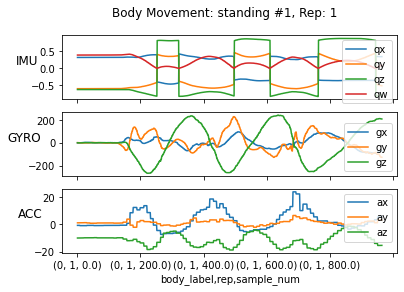

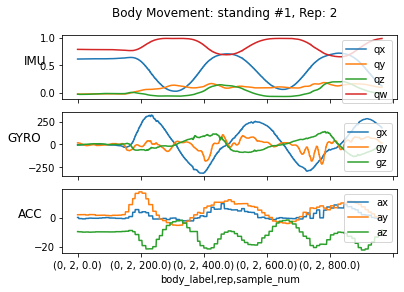

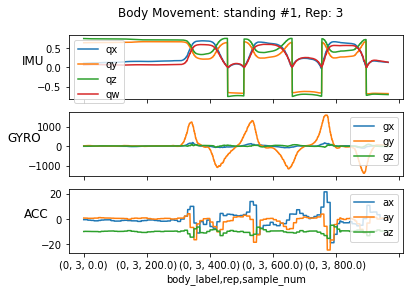

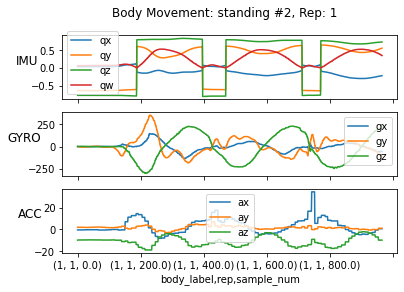

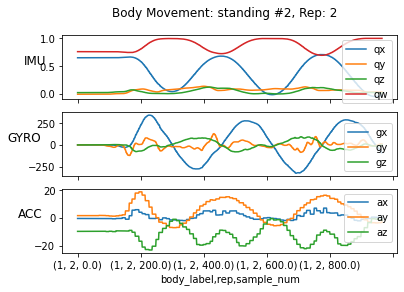

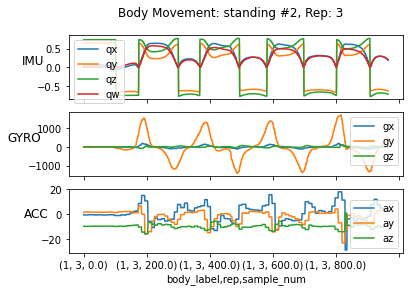

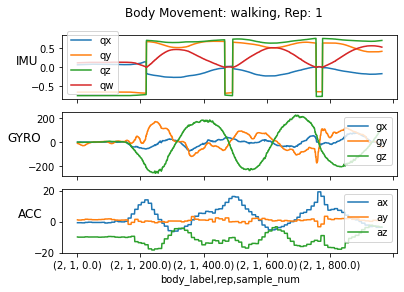

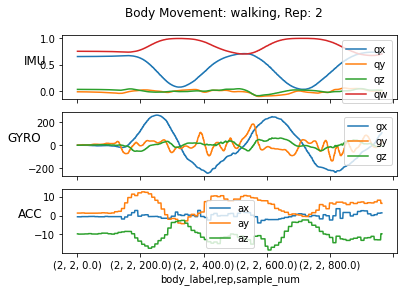

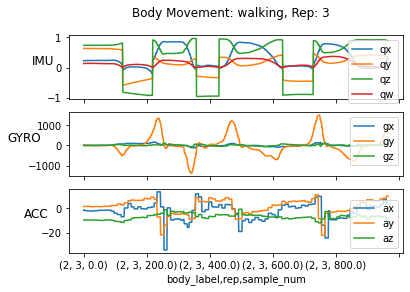

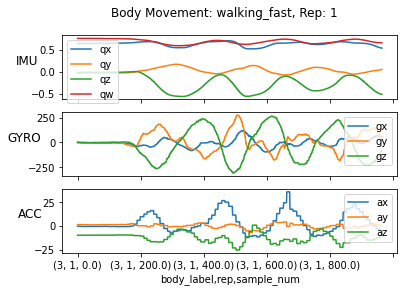

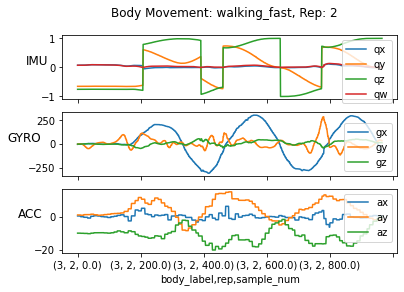

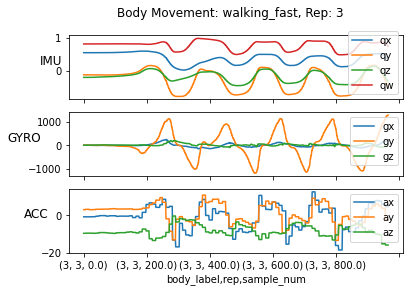

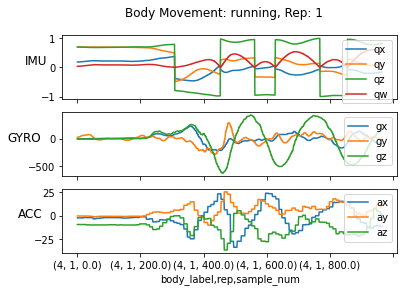

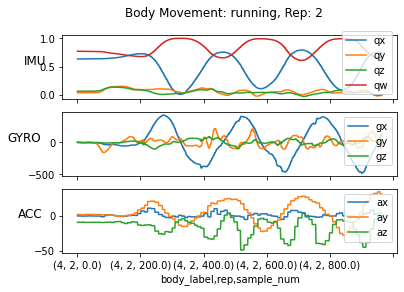

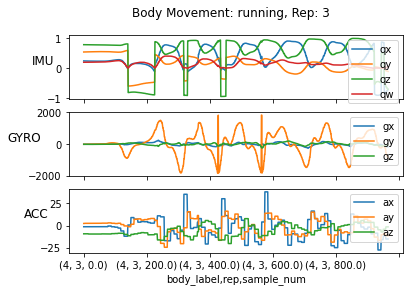

In [3]:
data_groups = [IMU_CHANNELS, GYRO_CHANNELS, ACC_CHANNELS]
sensors = ["IMU", "GYRO", "ACC"]

for (body, rep), observation in dataset.groupby(level=(0, 1)):
    fig, axes = plt.subplots(nrows=len(data_groups), ncols=1, sharex=True)
    fig.suptitle(f"Body Movement: {body_movement_code[body]}, Rep: {rep}")
    for group_idx, data_group in enumerate(data_groups):
        axes[group_idx].set_ylabel(sensors[group_idx], rotation=0, size="large")
        observation.plot(y=data_group, ax=axes[group_idx])

plt.show()

## Description of Movements

There are three distinct movement patterns in this data that can be characterized by gyroscope and accelerometer data and visualized by plotting the quaterions in euler format. Note that gravitational acceleration shows up as a constant -9.8 m/s/s when the device is oriented flat on a table.

1. Rotation about the Z axis with slight rotations in Y - this would look like turning a doorknob about a quarter turn. A quarter turn aligns well with the accelerometer readings of ax and az meeting at the peak of the rotation, meaning gravitational acceleration is perfectly split between the two at 45 degrees of rotation. There is wavering in the Y direction, which may be an artifact of turning the wrist drawing the forearm away from the middle of the body on the right and towards the body on the left.

2. Rotation about X. This would look someone moving their hand out to hit a key on a keyboard at waist height. We again see two axes, Y and Z, of acceleration meet at the midpoint of the gesture, meaning a 45 degree angle was reached.

3. Pure and rapid rotation about the Y axis with accleration in the X and Y axes that are in phase. For lack of a better description, this looks like someone brushing eraser dust off of a sheet of paper.

## Notable Features

### Time Domain
For each axis of each sensor, pairwise correlations will extract information on how the device's motion progresses.  For instance, the negative correlation of acceleration axes expresses a rotation while positive correlation expresses movement on a plane.  Correlation of the quaternion vectors, while harder to interpret, is a highly relevant feature difference between the first six observations.

Vector magnitude or RMS values extract the amount of motion over each axis while segmented means and variances capture local amplitude information.  To capture changes in direction, mean or zero crossings will show which axes are being exercised the most.

### Frequency Domain 
Spectral entropy may play a role here, but otherwise, time domain correlations and magnitudes seem to capture the bulk of the variation for the dynamics channels.  Spectral entropy could play a role in specifying the frequency of the motion, but would likely be a poor feature if the motion was done at different rates for different repetitions.  The EMG data benefitted from spectral entropy greatly because the muscle activations only occured at a certain frequency each  time.


### Plotting Motion and Gestures

By converting the IMU's quaternion axes to euler angles, we can get a notion of how the orientation of the device changes during each repetition.  While euler angles may exhibit discontinuities due to decreased dimensionality, these still provide a useful insight as to which repetitions are doing what gestures.

In [9]:
%matplotlib inline
for _, observation in dataset.groupby(level=(0, 1)):
    colormap = plt.cm.jet(np.linspace(0, 1, len(observation)))
    euler_angles = quaternion_to_euler_angle(observation[["qw", "qx", "qy", "qz"]])
    figure = plt.figure()
    ax = plt.axes(projection="3d")
    for idx, sample in euler_angles.iterrows():
        ax.scatter(
            sample["roll"], sample["pitch"], sample["yaw"], "*", color=colormap[idx]
        )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
extractors = {}

# Dynamics Features

extractors.update(
    {
        channel: [
            FeatureExtractor("rms", lambda x: np.sqrt(np.sum(x ** 2))),
            FeatureExtractor("var", np.var),
            FeatureExtractor("pk-pk", lambda x: (np.max(x) - np.min(x))),
        ]
        for channel in GYRO_CHANNELS
    }
)

# Mixed channel features
extractors.update(
    {
        q_pair: [FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0, 1])]
        for q_pair in itertools.combinations(IMU_CHANNELS, 2)
    }
)
extractors.update(
    {
        q_pair: [FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0, 1])]
        for q_pair in itertools.combinations(GYRO_CHANNELS, 2)
    }
)
extractors.update(
    {
        q_pair: [FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0, 1])]
        for q_pair in itertools.combinations(ACC_CHANNELS, 2)
    }
)


results = process_dataframe(dataset, extractors)
results

gx.rms    gx.var  ...  ('ax', 'az').corr  ('ay', 'az').corr
body_label rep                      ...                                      
0.0        1.0 -0.814012 -0.690736  ...          -0.512415          -0.613005
           2.0  1.105525  0.908946  ...           0.209733          -0.805278
           3.0 -0.782012 -0.680092  ...          -1.360913           1.631674
1.0        1.0 -0.784482 -0.680374  ...          -0.658567          -0.865148
           2.0  1.276856  1.128994  ...           0.018262          -0.870535
           3.0 -0.614520 -0.611797  ...          -1.390909           1.847981
2.0        1.0 -1.024606 -0.751171  ...          -0.770998           1.167338
           2.0  0.671254  0.399734  ...           1.928400          -1.180159
           3.0 -0.607533 -0.621791  ...           0.011297           0.031450
3.0        1.0 -0.873701 -0.711065  ...          -0.163946          -0.099849
           2.0  1.166709  0.980946  ...           1.274261          -1.235576
           3.0 -0.387664 -0.496745  ...          -0.508140          -0.293340
4.0        1.0 -0.195110 -0.378017  ...          -0.110480          -0.113547
           2.0  2.148591  2.638982  ...           1.781714           0.805899
           3.0 -0.285295 -0.435814  ...           0.252700           0.592093

[15 rows x 21 columns]

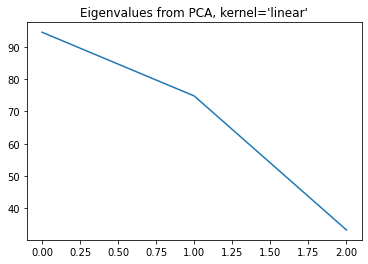

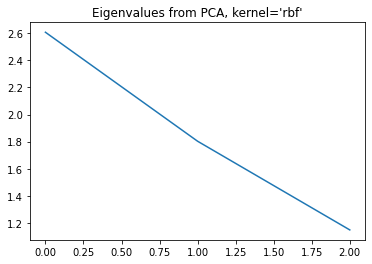

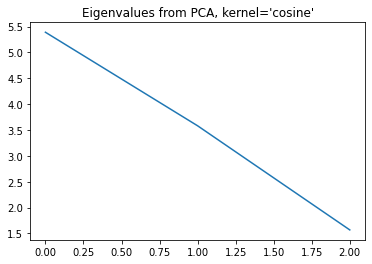

In [6]:
# Cluster with PCA

# Color repetitions to see pattern in clusters
color_map = {0: "g", 1: "b", 2: "r"}

pca_outputs = {}
for kernel in ["linear", "rbf", "cosine"]:
    pca = KernelPCA(n_components=3, kernel=kernel)
    pca.fit(results)
    plt.figure()
    plt.plot(pca.eigenvalues_)
    plt.title(f"Eigenvalues from PCA, {kernel=}")
    pca_outputs[kernel] = pd.DataFrame(data=pca.transform(results), index=results.index)

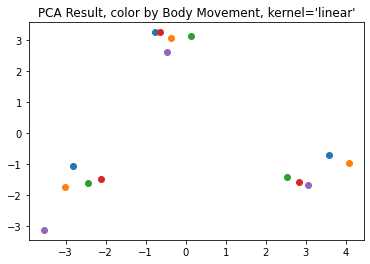

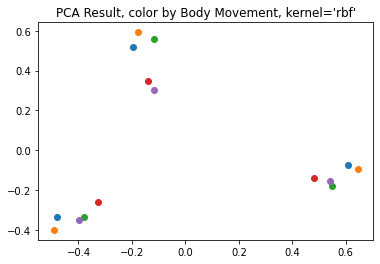

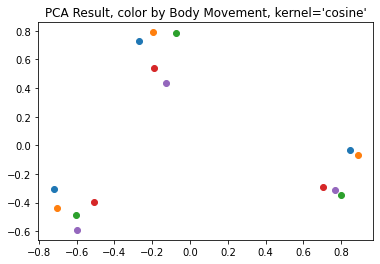

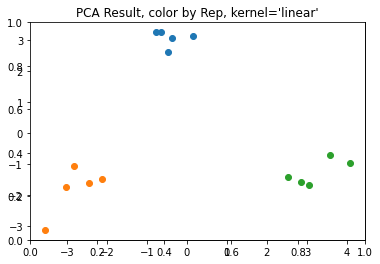

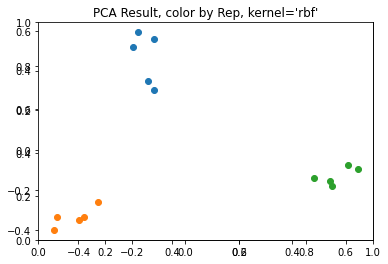

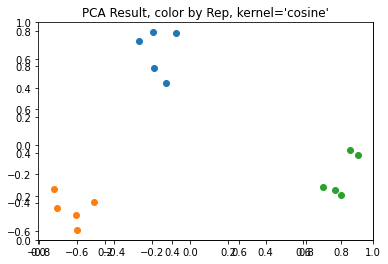

In [7]:
# Color clusters by body for each kernel
for kernel, frame in pca_outputs.items():
    plt.figure()
    plt.title(f"PCA Result, color by Body Movement, {kernel=}")
    for _, subframe in frame.groupby(level=0):
        plt.scatter(subframe.values[:, 0], subframe.values[:, 1])
    plt.show()

# Color clusters by rep for each kernel
for kernel, frame in pca_outputs.items():
    plt.figure()
    plt.title(f"PCA Result, color by Rep, {kernel=}")
    ax = plt.axes()
    for _, subframe in frame.groupby(level=1):
        plt.scatter(subframe.values[:, 0], subframe.values[:, 1])

    plt.show()